# 0. Load parameters


In [1]:
# | tags: [parameters]
subject = "101"

In [1]:
# | tags: [parameters]
# Injected Parameters
subject = 128

In [2]:
import os
import mne
from pathlib import Path
from spectral.utils import print_date_time, read_parameters, config_project
from spectral.preproc import load_data, zapline_clean, get_bad_lof
from spectral.preproc import detrending, apply_pyprep, get_bad_channels
from spectral.viz import plot_step, plot_bad_channels, plot_epochs
from spectral.specparam import specparam2pandas
import matplotlib.pyplot as plt

import numpy as np

from spectral.ica import (
    compute_ica,
    label_components_ica,
    plot_ica_components,
    plot_removed_components,
)

# mne.viz.set_browser_backend("matplotlib")
mne.viz.set_browser_backend("qt")
mne.set_config("MNE_BROWSER_THEME", "light")
# matplotlib.use("Agg")

config = read_parameters()
my_paths = config_project(subject)

project_path = my_paths["project_path"]
raw_preproc_path = my_paths["raw_preproc_path"]
print(raw_preproc_path)
Path(raw_preproc_path).mkdir(parents=True, exist_ok=True)

figures_path = my_paths["figures_path"]
specparam_path = my_paths["specparam_path"]
Path(specparam_path).mkdir(parents=True, exist_ok=True)


print_date_time()

2024-06-15 03:33:37,284 - OpenGL.acceleratesupport - INFO - No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'


Using qt as 2D backend.
/Users/daniel/PhD/Projects/psd-path/analysis/data/raw/sub-128/
2024-06-15 03:33:37


This file contains preprocessing files after downsampling them.


# 1. Preprocess raw data


In [3]:
bad_channels = [
    "E67",
    "E73",
    "E82",
    "E91",
    "E92",
    "E102",
    "E111",
    "E120",
    "E133",
    "E145",
    "E165",
    "E174",
    "E187",
    "E199",
    "E208",
    "E209",
    "E216",
    "E217",
    "E218",
    "E219",
    "E225",
    "E226",
    "E227",
    "E228",
    "E229",
    "E230",
    "E231",
    "E232",
    "E233",
    "E234",
    "E235",
    "E236",
    "E237",
    "E238",
    "E239",
    "E240",
    "E241",
    "E242",
    "E243",
    "E244",
    "E245",
    "E246",
    "E247",
    "E248",
    "E249",
    "E250",
    "E251",
    "E252",
    "E253",
    "E254",
    "E255",
    "E256",
]

fline = 50
h_freq = 45
l_freq = 1

filter_params = {
    "l_freq": l_freq,
    "h_freq": h_freq,
    "h_trans_bandwidth": "auto",
    "fir_window": "hamming",
    "fir_design": "firwin",
    "phase": "zero",
    "picks": ["ecg", "eeg"],
}

raw = load_data(subject, project_path=project_path)

total_duration = raw.times[-1]
iir_params = dict(order=8, ftype="butter")
raw_filtered = (
    raw.copy()
    .drop_channels(bad_channels)
    .filter(l_freq=l_freq, h_freq=None)
    .filter(l_freq=None, h_freq=40.0, method="iir", iir_params=iir_params, verbose=True)
    # .notch_filter(freqs=[fline], phase="zero", method="iir")
    # .filter(**filter_params)
    # .crop(tmin=3.0, tmax=total_duration - 3, include_tmax=True)
    .crop(tmin=3.0, tmax=100, include_tmax=True)
)

Loading data from /Users/daniel/PhD/Projects/psd-path/data/raw/BIDS/sub-128/ses-01/eeg/sub-128_ses-01_task-rest_eeg.set
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 2 contiguous segments
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    2.7s


Filtering raw data in 2 contiguous segments
Setting up low-pass filter at 40 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoff at 40.00 Hz: -6.02 dB



Effective window size : 2.048 (s)
Plotting power spectral density (dB=True).


Text(0.5, 1.0, 'sub-101 PSD')

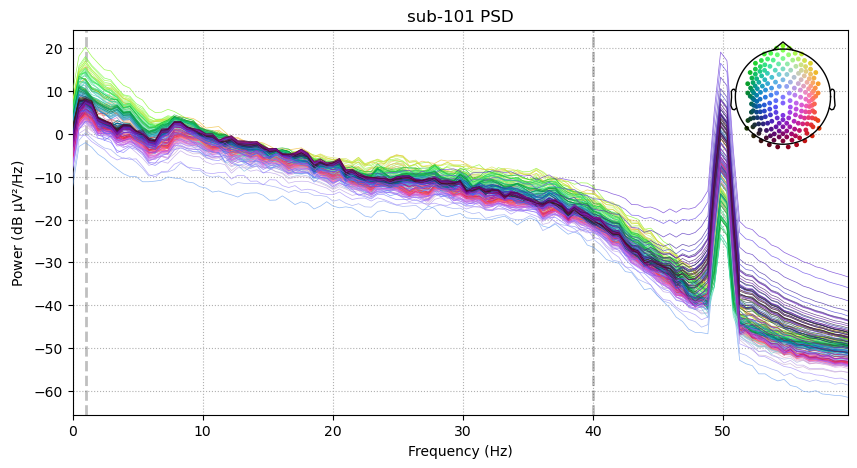

In [43]:
fig, ax = plt.subplots(figsize=(10, 5))
raw_psd = raw_filtered.compute_psd(
    fmax=60.0, method="welch", picks="eeg", exclude="bads"
).plot(average=False, picks="eeg", exclude="bads", show=False, axes=ax, amplitude=False)
ax.set_title(f"sub-{subject} PSD")

In [37]:
raw_filtered.plot(
    scalings=dict(eeg=1e-4),
)

Using pyopengl with version 3.1.6


Channels marked as bad:
['E44']


Setting up low-pass filter at 40 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoff at 40.00 Hz: -6.02 dB



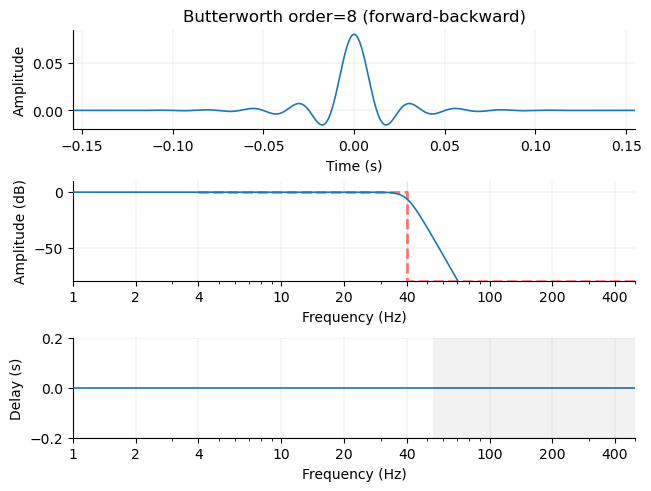

In [30]:
from mne.viz import plot_filter, plot_ideal_filter
from scipy import signal

sfreq = 1000.0
f_p = 40.0
nyq = sfreq / 2.0  # the Nyquist frequency is half our sample rate
freq = [0, f_p, f_p, nyq]
gain = [1, 1, 0, 0]
flim = (1.0, sfreq / 2.0)  # frequencies
dlim = (-0.2, 0.2)  # delays
duration = 1.0  # duration in seconds
kwargs = dict(flim=flim, dlim=dlim)

x = np.zeros(int(sfreq * duration) + 1)
iir_params = dict(order=8, ftype="butter")
filt = mne.filter.create_filter(
    x, sfreq, l_freq=None, h_freq=f_p, method="iir", iir_params=iir_params, verbose=True
)
plot_filter(filt, sfreq, freq, gain, "Butterworth order=8", compensate=True, **kwargs)
x_steep = signal.sosfiltfilt(filt["sos"], x)

Effective window size : 2.048 (s)
Plotting power spectral density (dB=True).


Text(0.5, 1.0, 'sub-101 PSD')

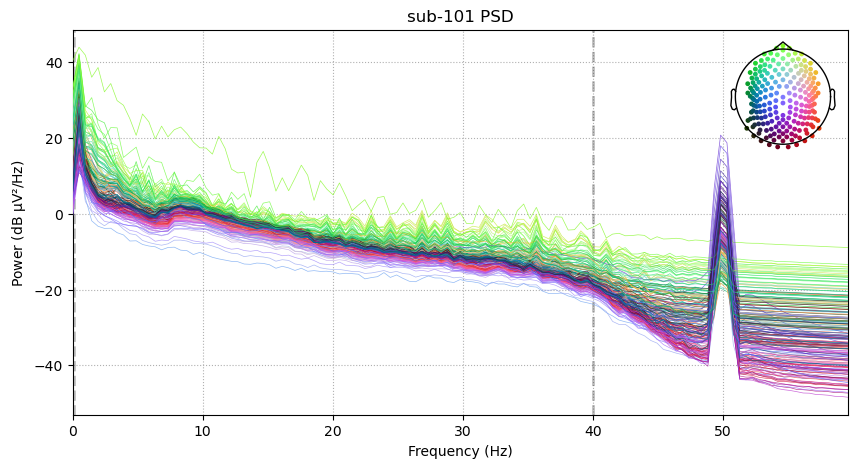

Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 73 events and 4000 original time points ...
0 bad epochs dropped
fitting finished
Dropped 34 epochs: 0, 1, 4, 5, 8, 9, 12, 13, 14, 15, 18, 20, 24, 26, 27, 31, 32, 33, 34, 35, 36, 38, 41, 43, 48, 54, 55, 58, 63, 64, 65, 66, 67, 72


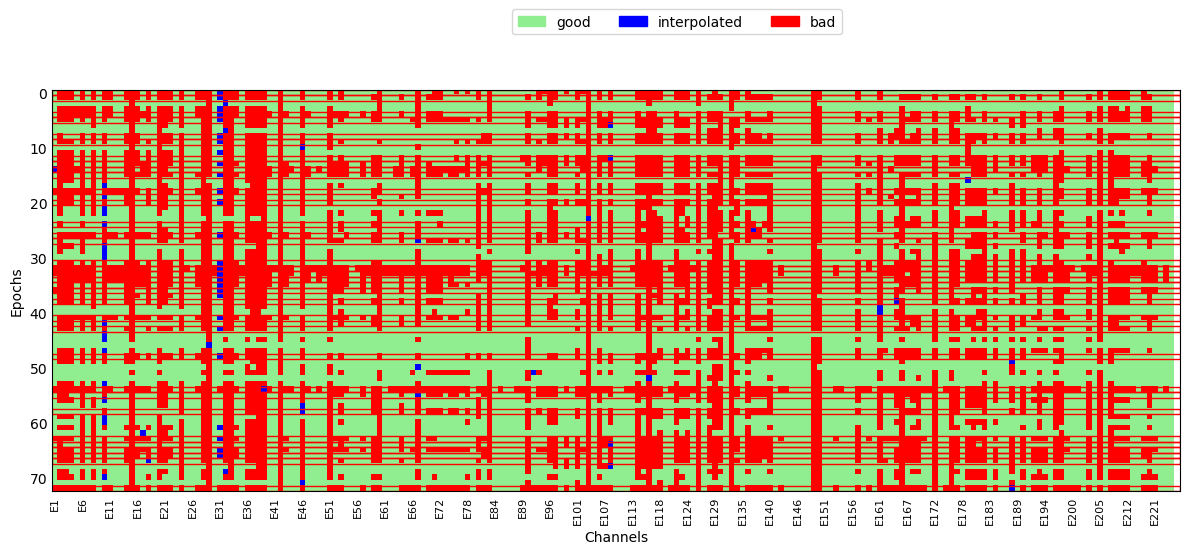

Additional 25 bad channels found:['E15', 'E20', 'E24', 'E28', 'E29', 'E32', 'E33', 'E36', 'E37', 'E38', 'E39', 'E42', 'E46', 'E51', 'E104', 'E116', 'E126', 'E129', 'E132', 'E149', 'E150', 'E161', 'E166', 'E172', 'E205']


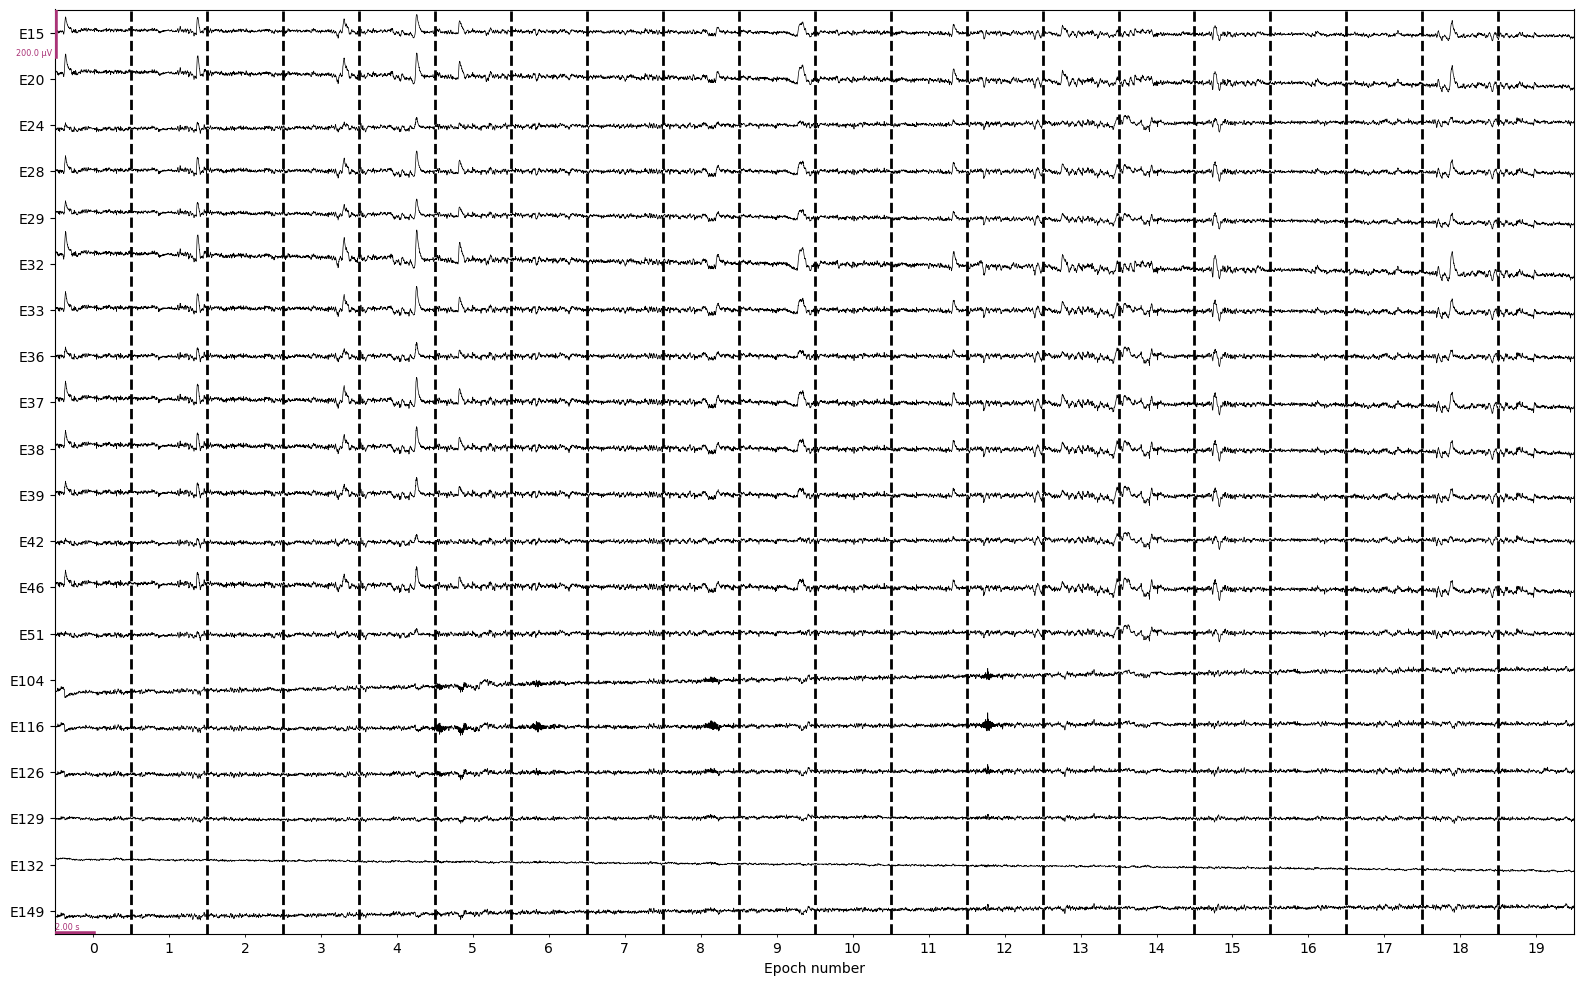

In [17]:
from spectral.epochs import create_epochs, get_reject_log

# raw_annotated = raw_pyprep.copy()
# Set the duration of the epochs
duration = 4.0  # duration of epochs in seconds

# Create 1-second epochs from the continuous data
epochs = mne.make_fixed_length_epochs(raw_filtered, duration=duration, preload=True)

reject_log = get_reject_log(epochs, resample=125, n_interpolate=[1], consensus=[0.35])
reject_plot = reject_log.plot("vertical")


# Drop channels with more than 40% bad epochs
BADS_THRESHOLD = 0.80

bads = np.logical_or(reject_log.labels == 1, reject_log.labels == 2)

bad_channel = bads.mean(axis=0)
# print(bad_channel)
epochs.info
channel_names = epochs.info["ch_names"]
bad_channels_by_epochs = [
    name for name, value in zip(channel_names, bad_channel) if value > BADS_THRESHOLD
]
print(
    f"Additional {len(bad_channels_by_epochs)} bad channels found:{
        bad_channels_by_epochs}"
)

# epochs.info["bads"].extend(bad_channels_by_epochs)
try:
    bad_channel_plot_additional = epochs.plot(
        picks=bad_channels_by_epochs,
        scalings=dict(eeg=1e-4),
        show_scrollbars=False,
    )
except Exception as e:
    print(f"An error occurred: {e}")

Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 2000 original time points ...
0 bad epochs dropped
Estimating rejection dictionary for eeg
The rejection dictionary is {'eeg': 0.0013874537353515625}
    Rejecting  epoch based on EEG : ['E241']
    Rejecting  epoch based on EEG : ['E110']
    Rejecting  epoch based on EEG : ['E110']
    Rejecting  epoch based on EEG : ['E110']
    Rejecting  epoch based on EEG : ['E110']
    Rejecting  epoch based on EEG : ['E110']
    Rejecting  epoch based on EEG : ['E110']
    Rejecting  epoch based on EEG : ['E110']
    Rejecting  epoch based on EEG : ['E110']
    Rejecting  epoch based on EEG : ['E110']
    Rejecting  epoch based on EEG : ['E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E18', 'E19', 'E20', 'E21', 'E22', 'E25', 'E26', 'E27', 'E28', 'E31', 'E32', 'E33', 'E34', 'E35', 'E37', 'E38', 'E46', 'E110']
    Rejecting  epoch based on EEG : ['

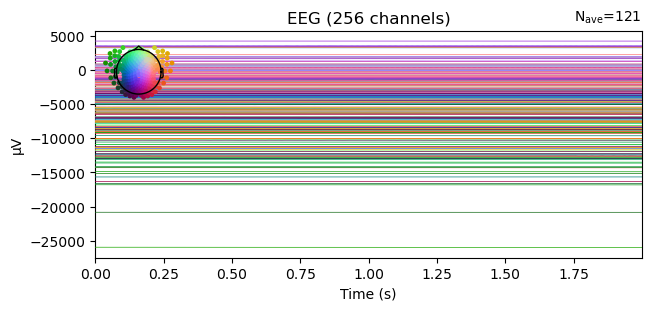

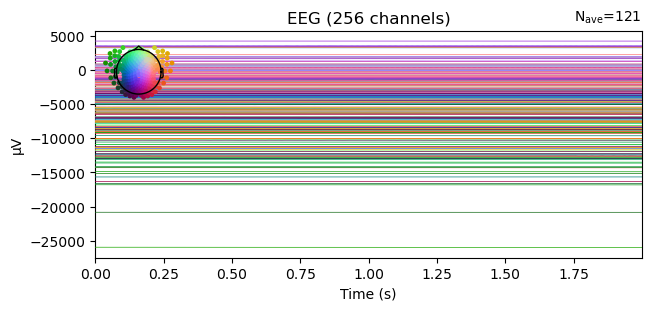

In [14]:
import mne

# Set the duration of the epochs
duration = 2.0  # duration of epochs in seconds

# Create 1-second epochs from the continuous data
epochs = mne.make_fixed_length_epochs(raw, duration=duration, preload=True)

from autoreject import get_rejection_threshold  # noqa

# We can use the `decim` parameter to only take every nth time slice.
# This speeds up the computation time. Note however that for low sampling
# rates and high decimation parameters, you might not detect "peaky artifacts"
# (with a fast timecourse) in your data. A low amount of decimation however is
# almost always beneficial at no decrease of accuracy.
reject = get_rejection_threshold(epochs)
print("The rejection dictionary is %s" % reject)
epochs.drop_bad(reject=reject)
epochs.average().plot()


Effective window size : 2.048 (s)
Plotting power spectral density (dB=True).


Text(0.5, 1.0, 'sub-101 PSD')

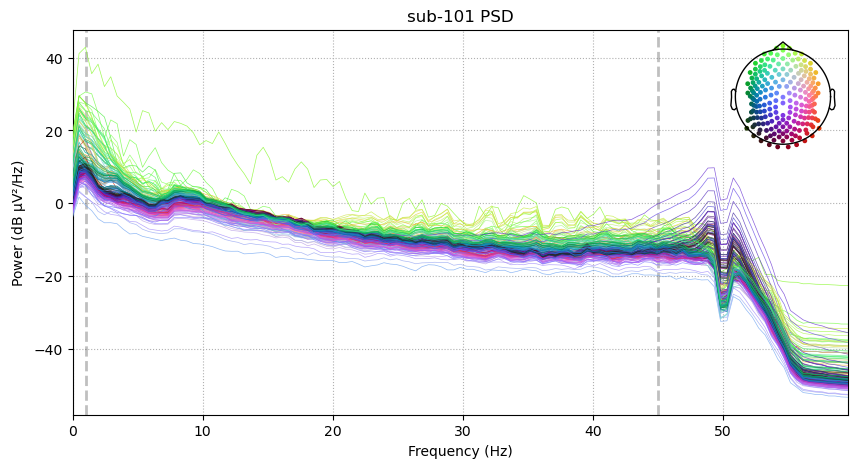

In [5]:
bad_channels_by_ransac = apply_pyprep(raw_filtered, output="dict", as_dict=True)

print(bad_channels_by_ransac["bad_all"])

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


Setting up high-pass filter at 1 Hz


FIR filter parameters


---------------------


Designing a one-pass, zero-phase, non-causal highpass filter:


- Windowed time-domain design (firwin) method


- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation


- Lower passband edge: 1.00


- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)


- Filter length: 413 samples (3.304 s)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


Executing RANSAC
This may take a while, so be patient...


Finding optimal chunk size : 102


Total # of chunks: 2


Current chunk:


1


2



RANSAC done!


[]


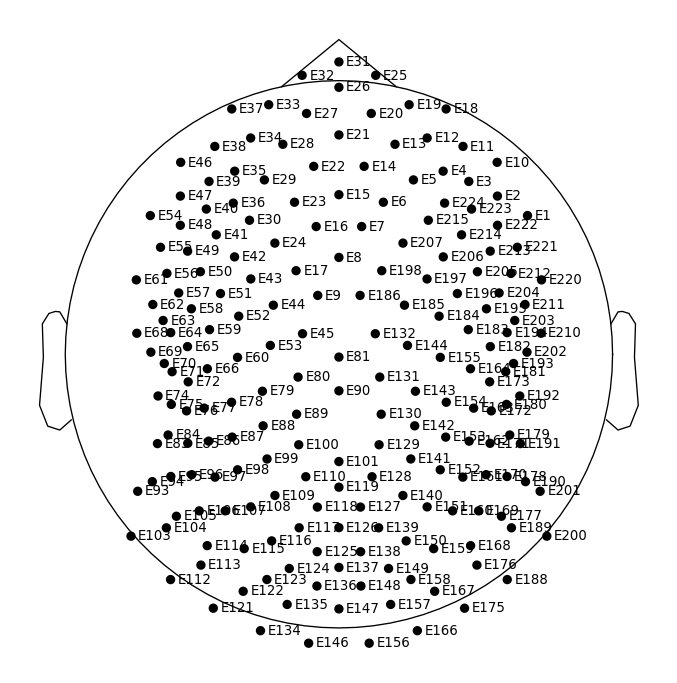

An error occurred: No appropriate channels found for the given picks ([])
Writing /Users/daniel/PhD/Projects/psd-path/analysis/sub-128_filtered_raw.fif


/var/folders/xq/sl7xjp_95qx7wfngy6s6vvg00000gn/T/ipykernel_56008/175166296.py:14: RuntimeWarning: Acquisition skips detected but did not fit evenly into output buffer_size, will be written as zeroes.
  raw_ransac.save(


Closing /Users/daniel/PhD/Projects/psd-path/analysis/sub-128_filtered_raw.fif


[done]


In [6]:
raw_ransac = raw_filtered.copy()
raw_ransac.info["bads"].extend(bad_channels_by_ransac["bad_all"])
sensor_plot = raw_ransac.plot_sensors(show_names=True)
try:
    raw_ransac.copy().pick(bad_channels_by_ransac["bad_all"]).plot(
        duration=raw_ransac.times[-1],
        scalings=dict(eeg=1e-4),
        show_scrollbars=False,
    )
except Exception as e:
    print(f"An error occurred: {e}")


raw_ransac.save(
    f"{project_path}/analysis/sub-{subject}_filtered_raw.fif", overwrite=True
)

Not setting metadata


101 matching events found


No baseline correction applied


0 projection items activated


Using data from preloaded Raw for 101 events and 1251 original time points ...


17 bad epochs dropped


fitting finished


Dropped 2 epochs: 55, 58


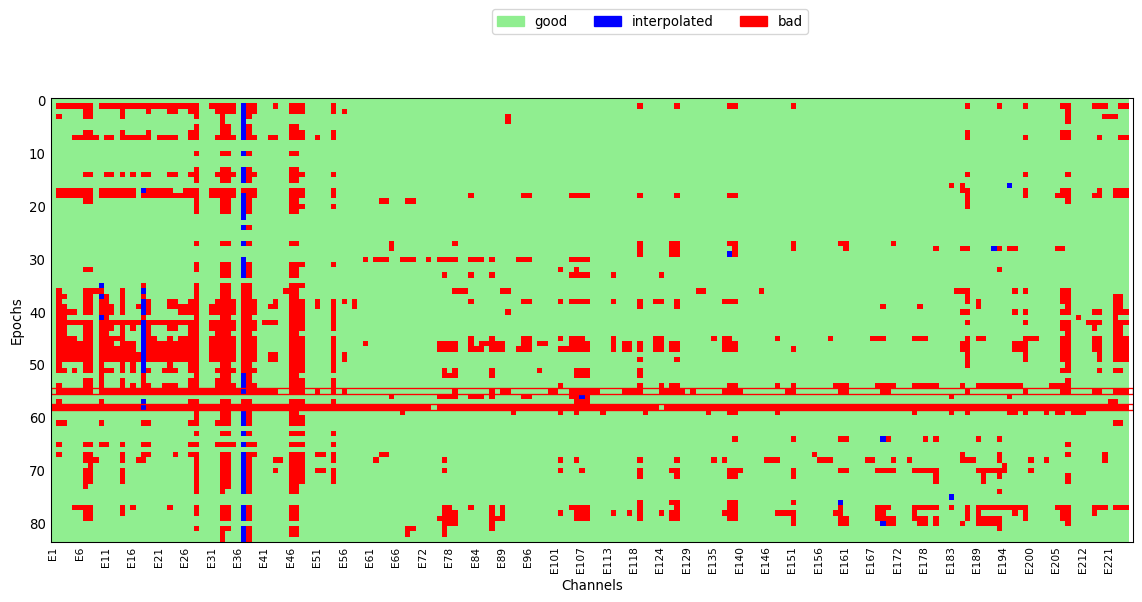

Additional 13 bad channels found:['E7', 'E8', 'E14', 'E28', 'E33', 'E34', 'E37', 'E38', 'E46', 'E47', 'E48', 'E54', 'E207']


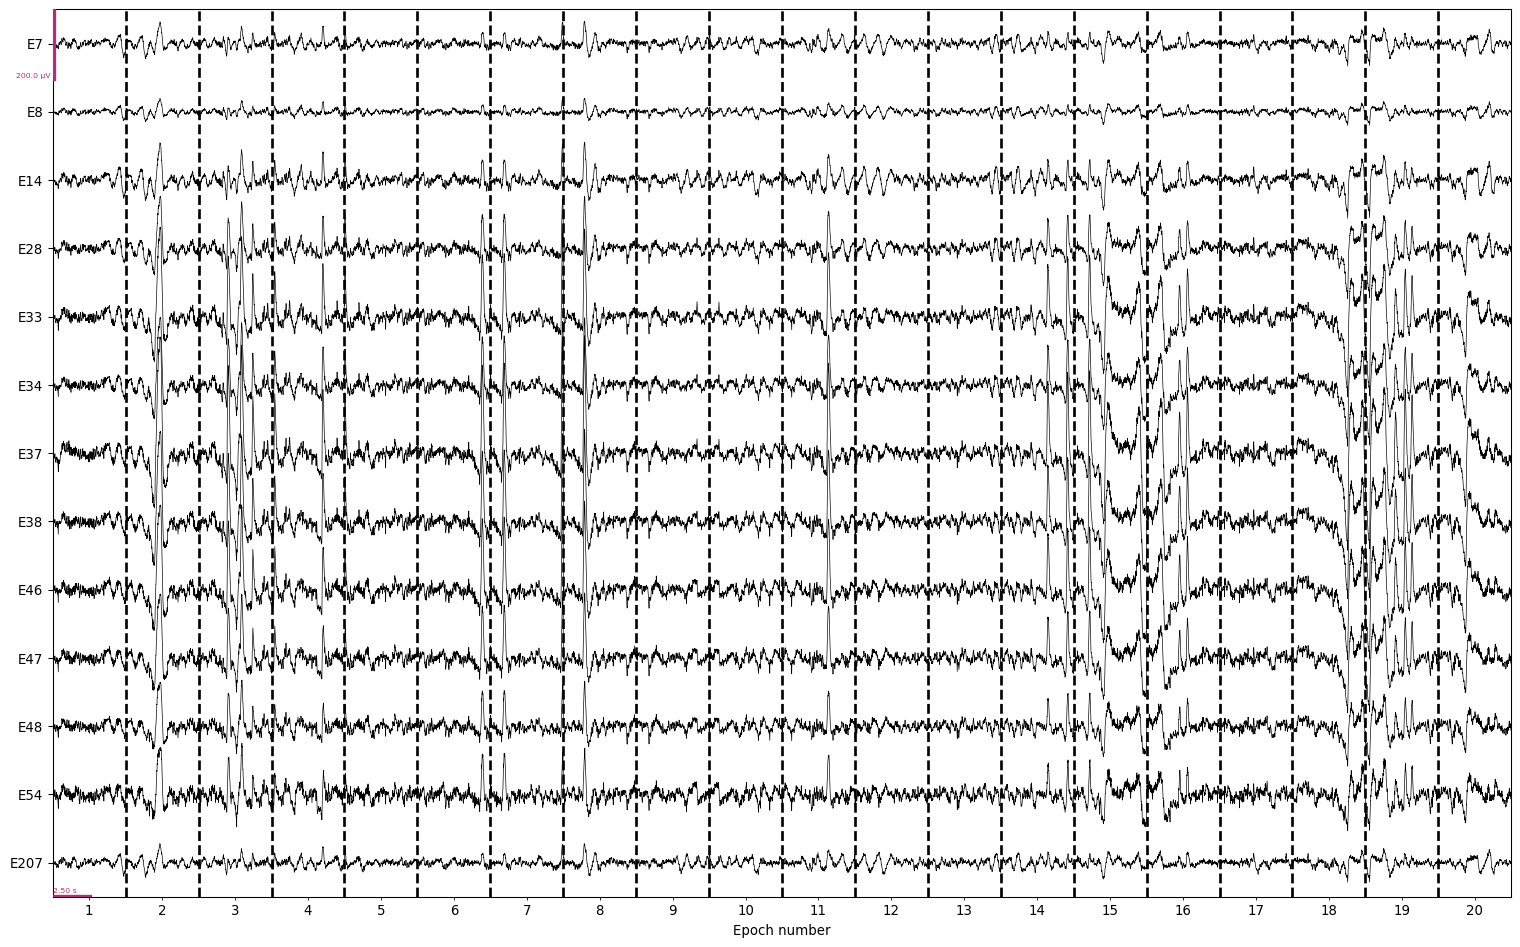

In [7]:
from spectral.epochs import create_epochs, get_reject_log

# raw_annotated = raw_pyprep.copy()
epochs = create_epochs(raw_ransac, overlap=1.5)

reject_log = get_reject_log(epochs, resample=125, n_interpolate=[1], consensus=[0.40])
reject_plot = reject_log.plot("vertical")


# Drop channels with more than 40% bad epochs
BADS_THRESHOLD = 0.40

bads = np.logical_or(reject_log.labels == 1, reject_log.labels == 2)

bad_channel = bads.mean(axis=0)
# print(bad_channel)
epochs.info
channel_names = epochs.info["ch_names"]
bad_channels_by_epochs = [
    name for name, value in zip(channel_names, bad_channel) if value > BADS_THRESHOLD
]
print(
    f"Additional {len(bad_channels_by_epochs)} bad channels found:{
        bad_channels_by_epochs}"
)

# epochs.info["bads"].extend(bad_channels_by_epochs)
try:
    bad_channel_plot_additional = epochs.plot(
        picks=bad_channels_by_epochs,
        scalings=dict(eeg=1e-4),
        show_scrollbars=False,
    )
except Exception as e:
    print(f"An error occurred: {e}")

In [8]:
sum(reject_log.bad_epochs)

2

Effective window size : 5.004 (s)


Plotting power spectral density (dB=True).


Averaging across epochs...


Effective window size : 5.004 (s)


Plotting power spectral density (dB=True).


Averaging across epochs...


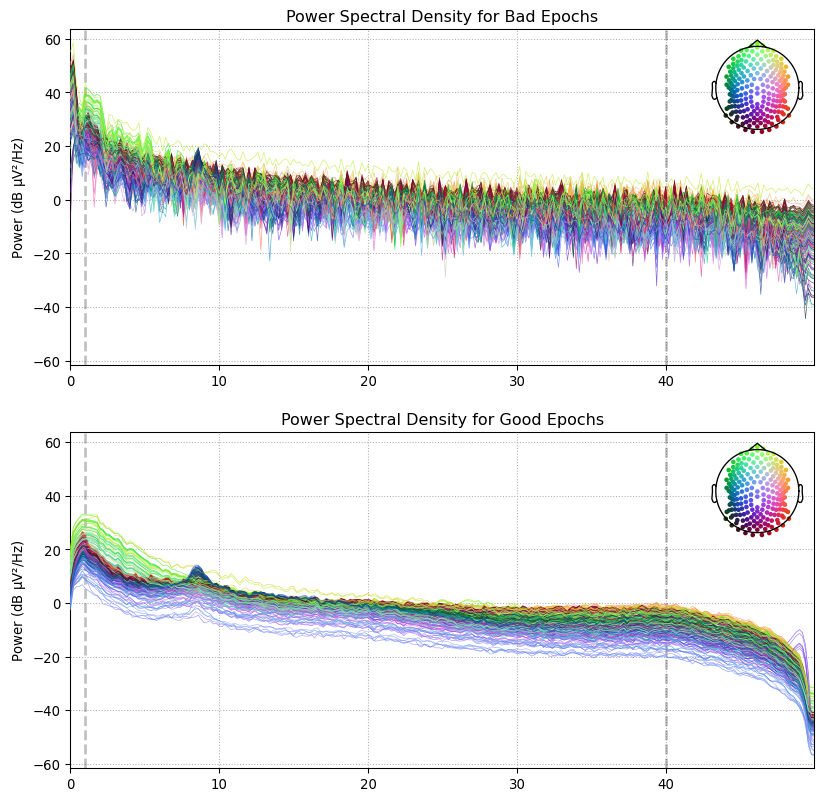

In [9]:
import matplotlib.pyplot as plt


def plot_psd(epochs, axs, title):
    epochs_plot_psd = epochs.compute_psd(
        method="welch", picks="eeg", fmax=50.0, exclude="bads"
    ).plot(
        average=False,
        picks="eeg",
        exclude="bads",
        show=False,
        amplitude=False,
        axes=axs,
    )
    axs.set_title(title)
    return epochs_plot_psd


if sum(reject_log.bad_epochs):
    # Create a figure with two subplots
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))
    epochs_plot_psd = plot_psd(
        epochs[reject_log.bad_epochs],
        axs=axs[0],
        title="Power Spectral Density for Bad Epochs",
    )
    epochs_plot_psd = plot_psd(
        epochs[~reject_log.bad_epochs],
        axs=axs[1],
        title="Power Spectral Density for Good Epochs",
    )
    # Get the y-limits of both plots
    ylim1 = axs[0].get_ylim()
    ylim2 = axs[1].get_ylim()

    # Set the same limits on the y-axis for both plots
    axs[0].set_ylim(min(ylim1[0], ylim2[0]), max(ylim1[1], ylim2[1]))
    axs[1].set_ylim(min(ylim1[0], ylim2[0]), max(ylim1[1], ylim2[1]))
    plt.show()
else:
    fig, axs = plt.subplots(1, 1, figsize=(10, 5))
    epochs_plot_psd = plot_psd(epochs, axs=axs, title="Power Spectral Density")
    plt.show()

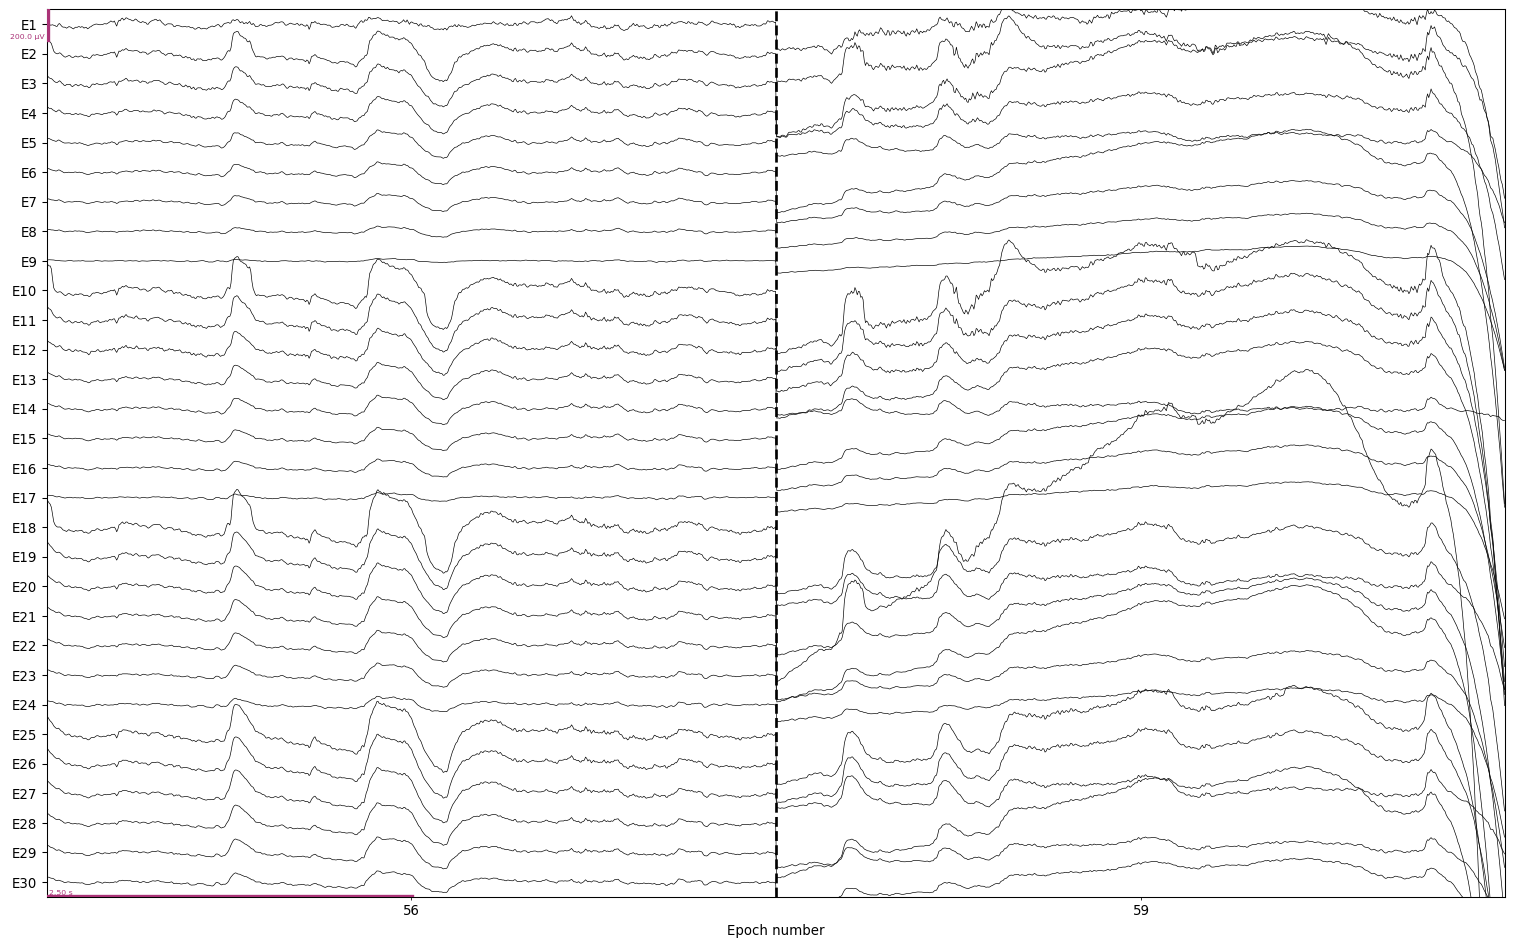

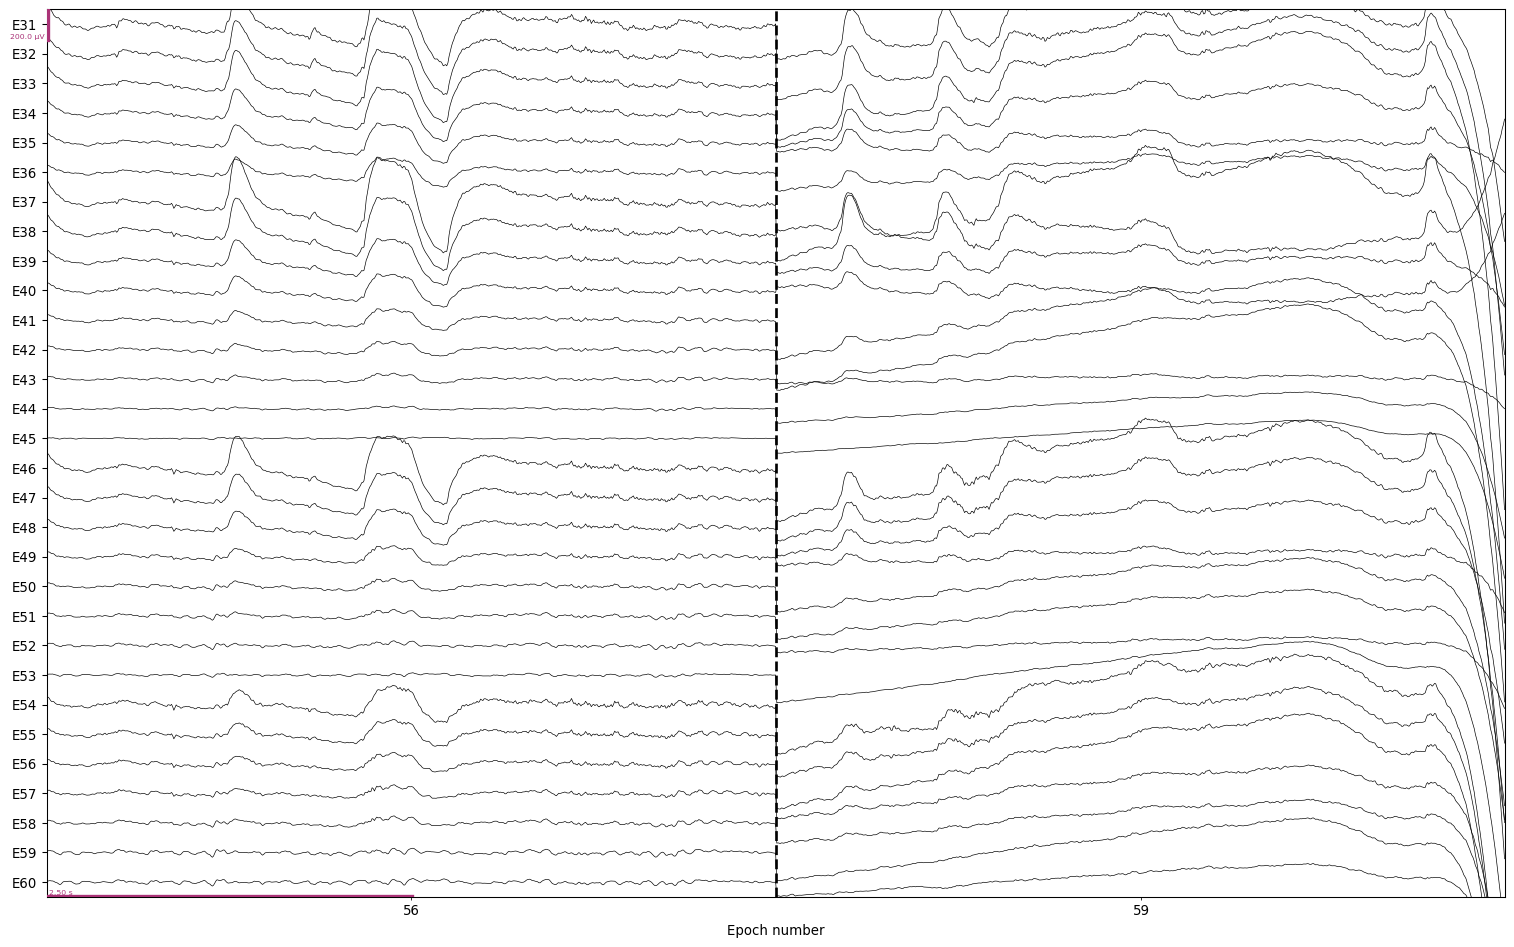

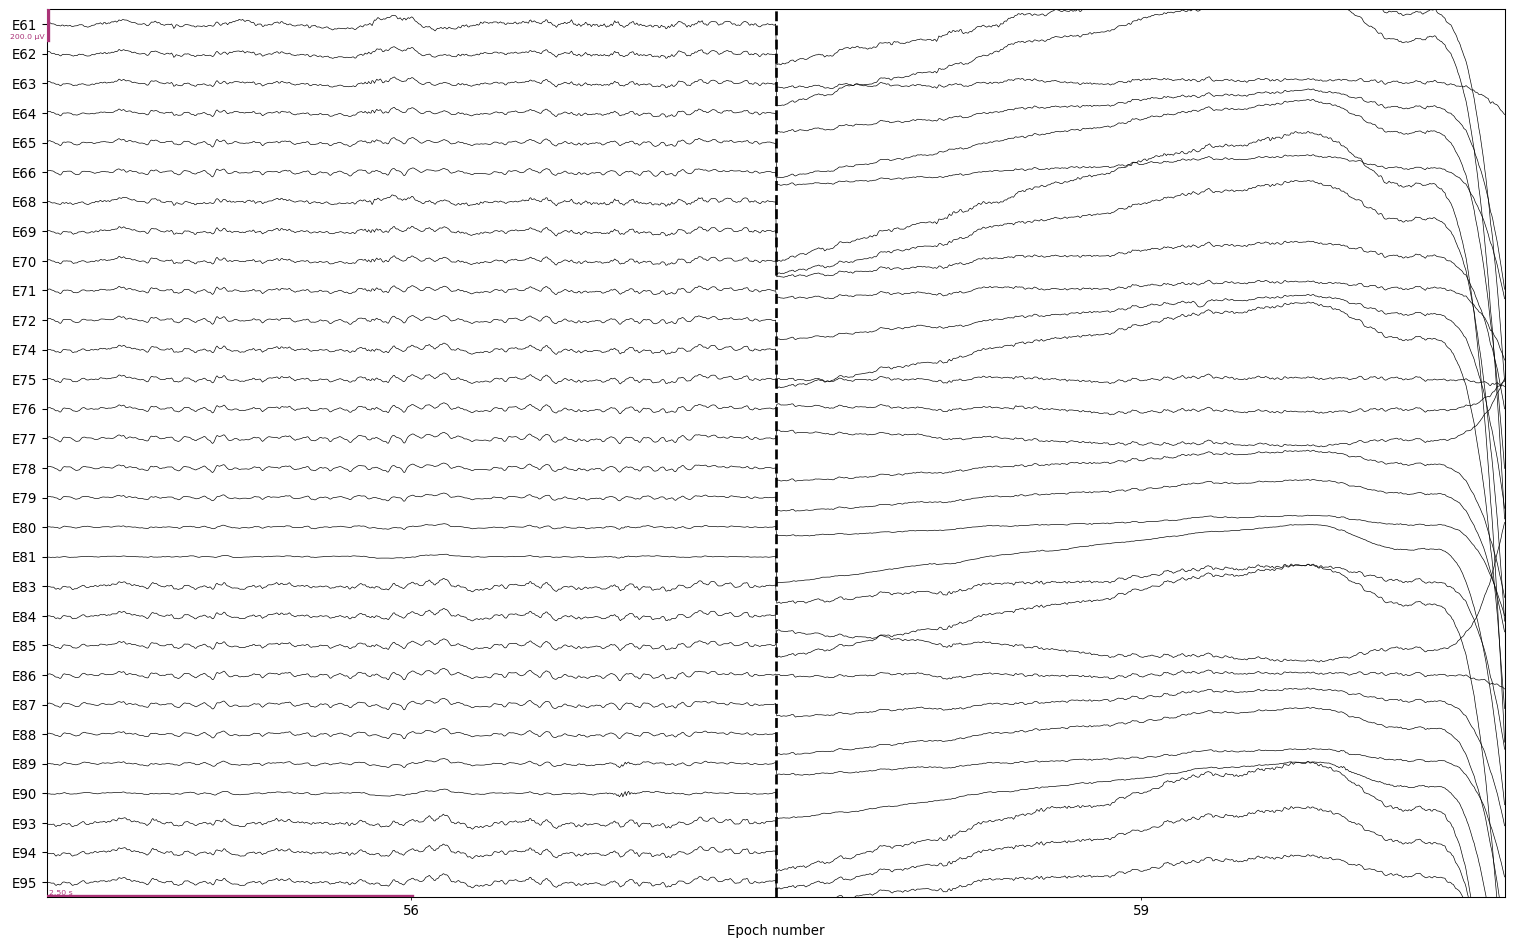

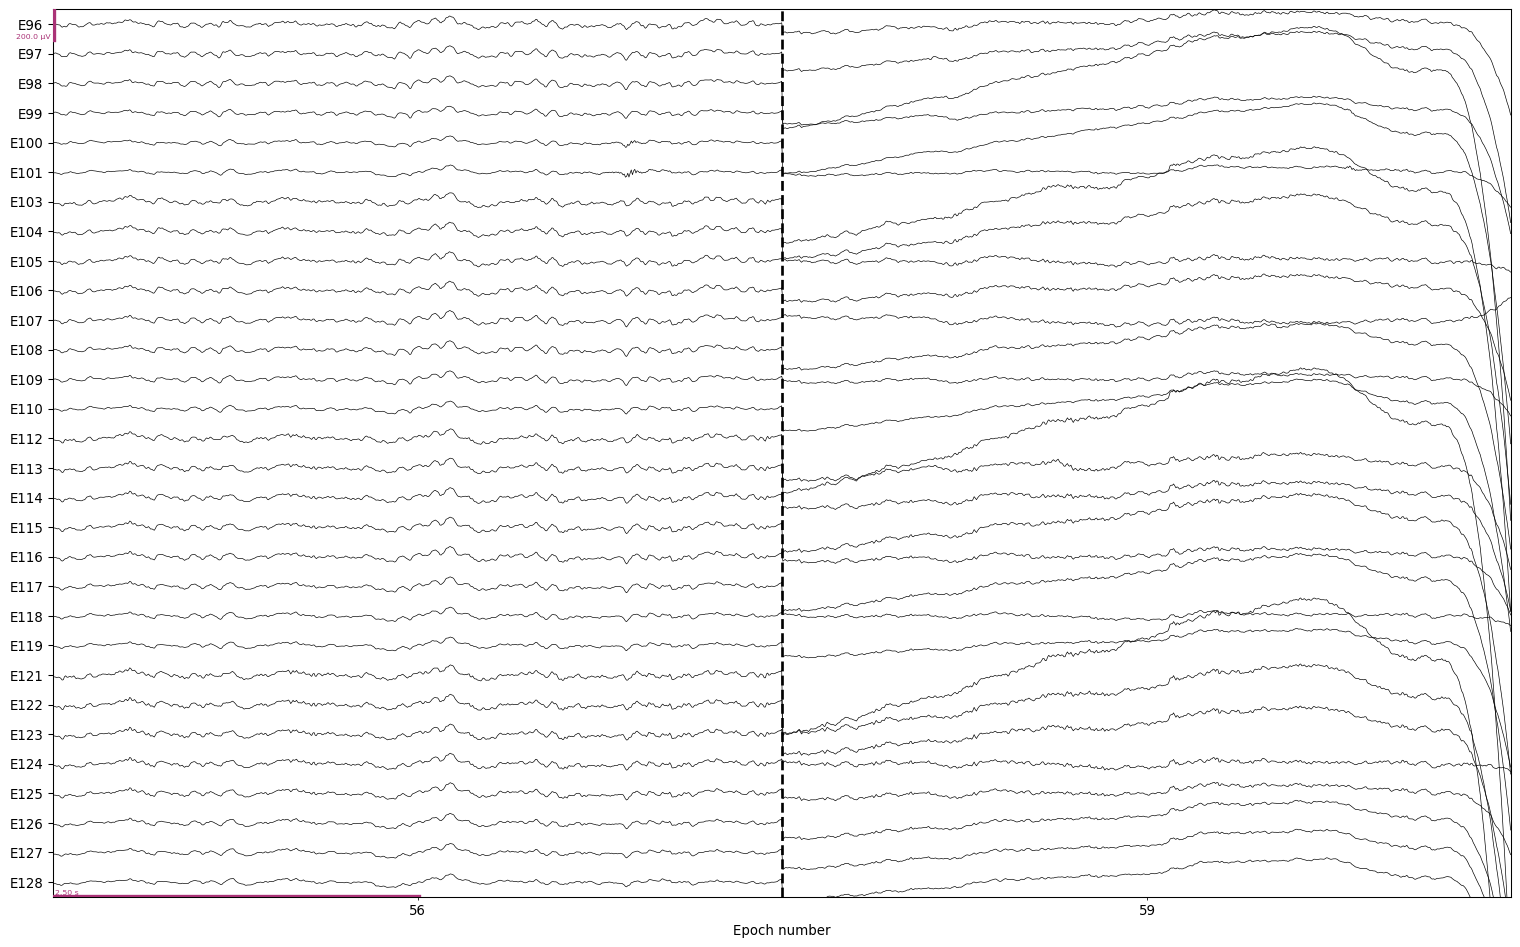

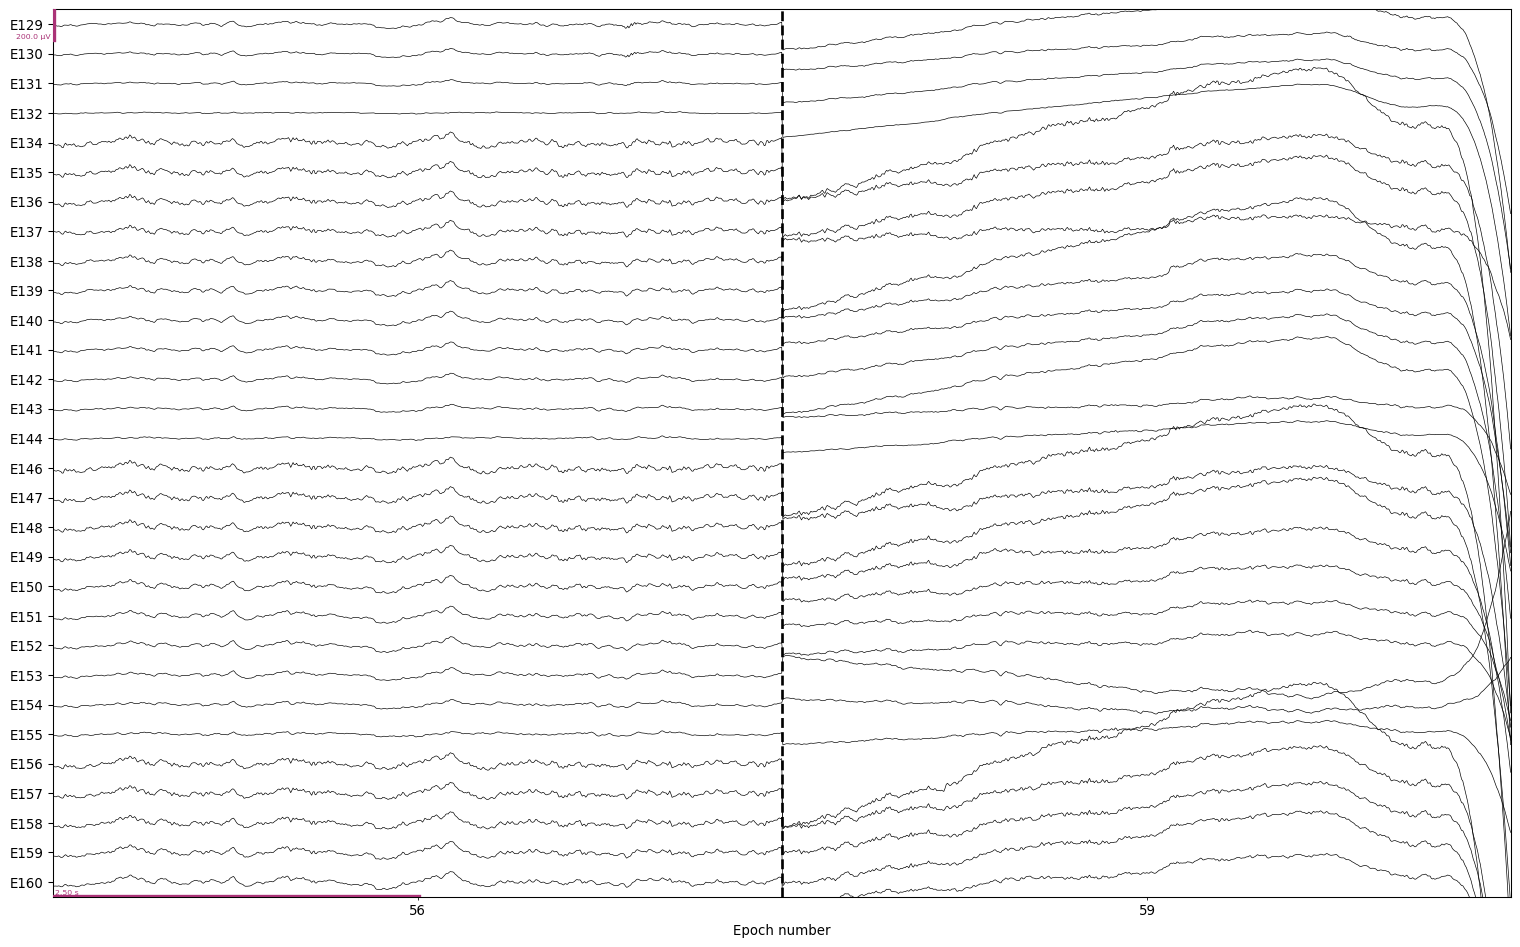

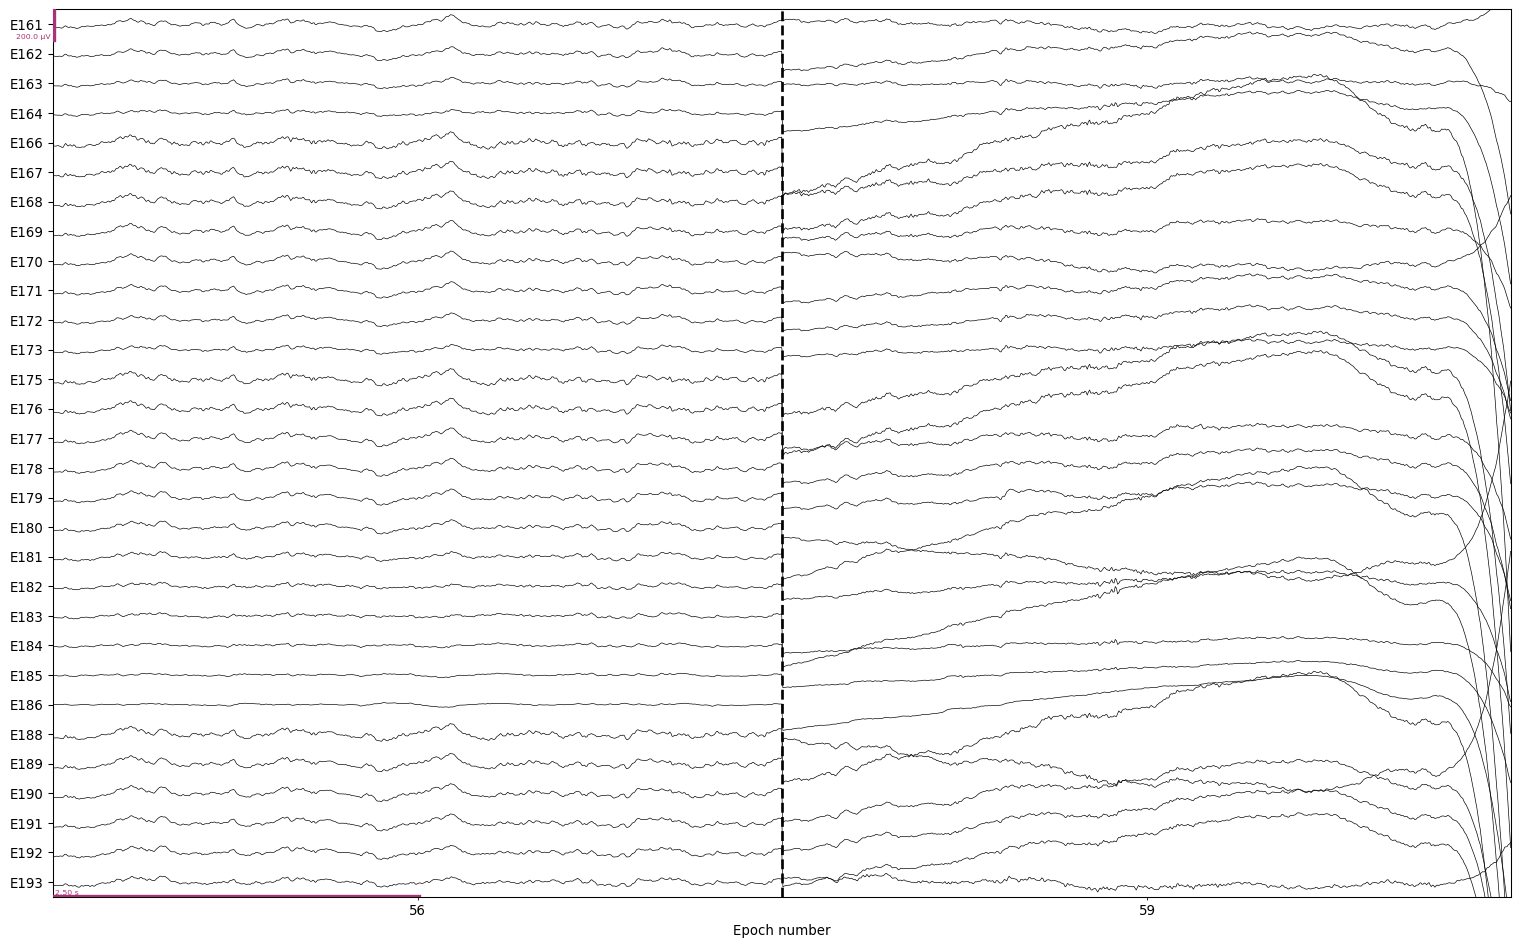

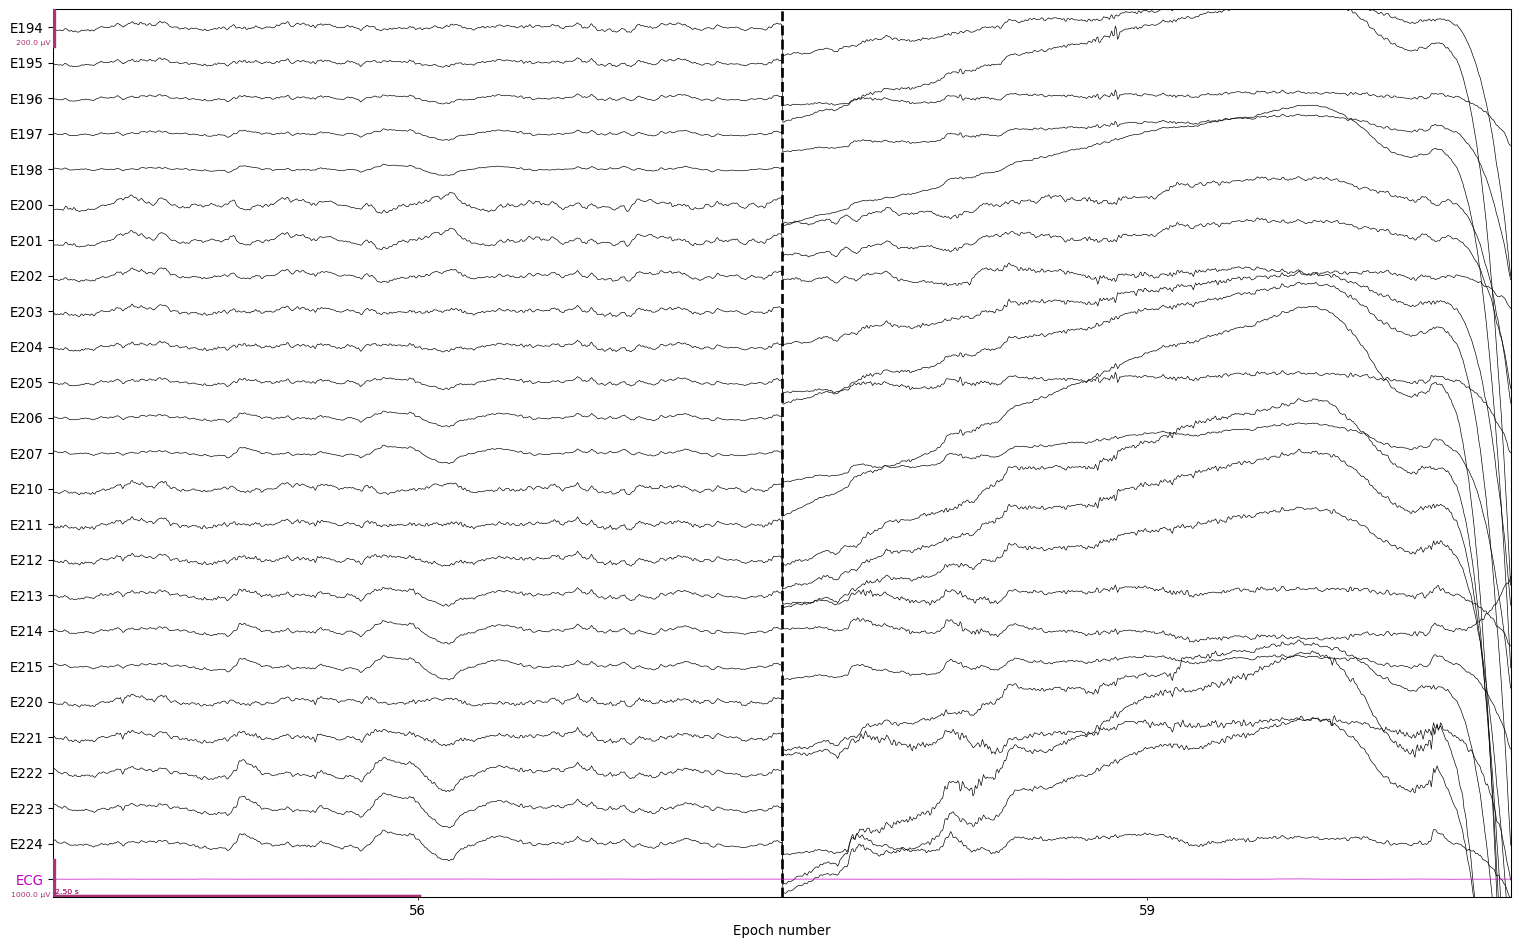

In [10]:
# Assuming 'raw' is your MNE raw object
# Get the list of all channels
all_channels = epochs.info["ch_names"]

# Get the list of bad channels
bad_channels = epochs.info["bads"]

# Get the list of good channels
good_channels = [ch for ch in all_channels if ch not in bad_channels]

# Get the indices of the good channels
good_channels_indices = [all_channels.index(ch) for ch in good_channels]

# Define the chunk size
chunk_size = 30

# Create chunks of the good channels
chunks = [
    good_channels_indices[i : i + chunk_size]
    for i in range(0, len(good_channels_indices), chunk_size)
]

try:
    # Now you can iterate over the chunks
    for chunk in chunks:
        # Do something with the chunk
        # print(chunk)
        mne.viz.plot_epochs(
            epochs=epochs[reject_log.bad_epochs],
            picks=chunk,
            show=False,
            scalings=dict(eeg=1e-4),
            n_channels=chunk_size,
            show_scrollbars=False,
        )
except Exception as e:
    print(f"An error occurred: {e}")

In [11]:
print(f"Sub{subject} -  removed {sum(reject_log.bad_epochs)} epochs")
print(f"Sub{subject} -  retained {len(epochs[~reject_log.bad_epochs])} epochs")
print_date_time()

epochs_good = epochs[~reject_log.bad_epochs]
epochs_good.save(
    f"{project_path}/analysis/sub-{subject}_good_epochs-epo.fif", overwrite=True
)

Sub128 -  removed 2 epochs
Sub128 -  retained 82 epochs
2024-05-01 23:50:43
